In [1]:
import csv
import re
import numpy as np
import pandas as pd
from pprint import pprint
import random
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
from __future__ import unicode_literals
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

## Setup The enviromental modules

### Import nltk

In [2]:
# Run in python console
import nltk; nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jaimemillan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words(['english','danish', 'dutch', 'english', 'finnish', 'french', 'german', 'hungarian', 'italian', 'norwegian', 'portuguese', 'russian', 'spanish', 'swedish', 'turkish'])
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

## Get The podcast Data 

### Here we import the podcast data. At the end we will have about ~100k podcast to utilize for our prediction model. 
### This csv files offer the following information regarding the podcasts:

- podcast description from url and itunes (str)
- podcast urls (str)
- podcast explicit content (boolean)
- podcast name 
- podcast picture

## Import the files Now! 
### first create string from a- to -z so we can import them!

In [4]:
import string 
strings = string.ascii_lowercase[1:26]
print(strings)

bcdefghijklmnopqrstuvwxyz


## Import big files with podcasts

In [5]:
df = pd.read_csv("all.csv",header=None)
df.columns

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], dtype='int64')

## Dictionary from numerical colums to podcast descriptions!


In [6]:
dict_num_colnames = {'slug':0,'name':1,'image_url':2,'feed_url':3,'website_url':4,
                      'itunes_owner_name':5,'itunes_owner_email':6,
                        'description':10,'itunes_summary':11}

In [7]:
dict_num_colnames = {'slug':0,'name':2,'image_url':3,'feed_url':4,'website_url':5,
                      'itunes_owner_name':6,'itunes_owner_email':7,
                        'description':11,'itunes_summary':12}

In [8]:
nbr_data =1000

## Let's Clean the podcast

### Some podcast description is misssing, or in asian languages hard to deal with. For now we will focus on English.
### Suggestion: Extend this analysis to other languages in the future

In [9]:
#backup file where we store the description, itunes_summary, name and website for each podcast
# some of this contes could be Nan, empty etc

new_df = pd.DataFrame({'content':df.iloc[:,dict_num_colnames['description']],    
                       'content2':df.iloc[:,dict_num_colnames['itunes_summary']],
                       'name': df.iloc[:,dict_num_colnames['name']],
                       'website_url': df.iloc[:,dict_num_colnames['website_url']]
                      })

## Here is where we erase asian languages

In [10]:
# Store the ids of english files (good ids list)

bad_ids= []
good_ids = []

# 
data = new_df.content[:].values.tolist()
data1 = new_df.content2[:].values.tolist()
pod_names = new_df.name[:].values.tolist()
pod_url = new_df.website_url[:].values.tolist()
#data = new_df.text[2:nbr_data].values.tolist()
new_data = []
for idx,_sentence in enumerate(data):
    
    if isinstance(_sentence,float):
        bad_ids.append(idx)
        continue
        
    tokens = _sentence.split()
    #tokens = tokens + data[idx].split()
    new_string = str()
    
    ADD_STRING = True
    for t in tokens:
        try:
            t.encode('utf-8')
            
            new_string = new_string +  t.encode('utf-8')+ ' '
            
        except:
            bad_ids.append(idx)
            ADD_STRING = False
            break
    if ADD_STRING:
        new_data.append(new_string)
        good_ids.append(idx);

### Now that we have the good files let's play with them

In [11]:
final_df =new_df.loc[:].drop(bad_ids)
data = list(new_data)
size =len(final_df);
new_index = [i for i in range(size)]
final_df.index = new_index
print("total number of podcast: " + str(len(new_data)))

total number of podcast: 92697


In [12]:
#data = new_df.content[:50].values.tolist()


# Remove Emails
new_data = []
for idx,sentence in enumerate(data):
    new_sentence=str()
    try:
        
        new_sentence =  re.sub('\S*@\S*\s?', '', sentence)
        
    except:
         continue;
            
    try:
        
        new_sentence =  re.sub('\s+', ' ', new_sentence)
        
    except:
         continue;   
    
    try:
        
        new_sentence =  re.sub("\'", "", new_sentence)
        
    except:
         continue;

    new_data.append(new_sentence)

## Note: the data list now contains the description of the podcast!

In [13]:
data = new_data
final_df.content = data
len(data)



92697

In [14]:
data[:10]

[u'10 ',
 u'A new project dedicated to all lovers of electronic music ',
 u'We chat about the movies, TV and pop-culturey stuff ',
 u'Florence Augusta Merriam Bailey was an American ornithologist and nature writer. She started observing bird behavior at a time when most bird study was based on collections and skins. By 1885, she began to write articles focusing on protecting birds. Her introduction of a birdwatching field guide, aimed at living birds, is considered the first in the tradition of modern bird guides. She wrote the first of these at the age of 26, initially as a series of notes in the Audubon Magazine and later as books. In "A-Birding on a Bronco," she writes an engaging memoir about her several trips to study birds on a ranch in California in the late 1800s. ',
 u'A radio show that plays bluegrass, old time and gospel music only by unsigned bands and discusses their playing style. ',
 u'A blend of soul,pop,funk,rhythm and blues and rock : songs by Musilosophy, singer song

## This is where we use TF-IDF and KNN to recommend podcasts based on tweeter activity

### Why TF_IDF?  Because of the following reasons:

- Is fast
- we can use all podcast
- it transform data into normalized vectors, perfect for cosine similarity

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)

## Now let's use TF-IDF to:

(1) transform the data

(2) apply dot product (cosine similarity) operations for recommendation

In [16]:
from guess_language import guessLanguage

In [17]:
dict_languages = {}

for idx,sentence in enumerate(data[:1]):
    if idx % 1000 == 0:
        
        language  = guessLanguage(sentence)
    #print(language)
    try:
        val = dict_languages[language]
        val = val + 1
        dict_languages[language] = val
    except:
        dict_languages[language] = 1
        
print(dict_languages)

{'UNKNOWN': 1}


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a27409e90>],
      dtype=object)

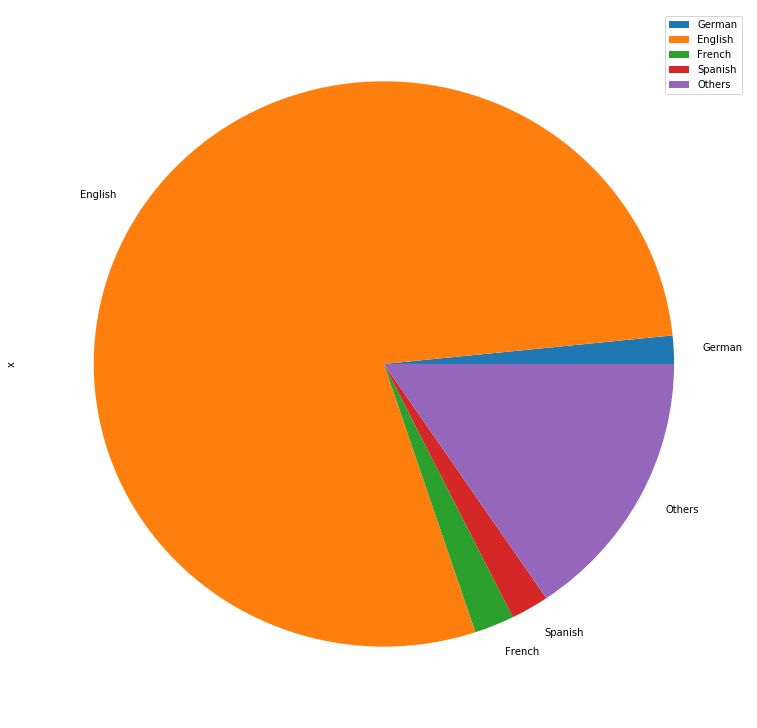

In [94]:
dict_pie = {'Others':0}
for key,val in dict_languages.items():
    if key == 'es':
        dict_pie['Spanish'] = val
        continue;
    if key == 'de':
        dict_pie['German'] = val
        continue
    if key == 'fr':
        dict_pie['French'] = val
        continue
    if key == 'en':
        dict_pie['English'] = val
        continue
    dict_pie['Others'] = dict_pie['Others'] + val
    
df = pd.DataFrame(dict_pie.values(), index=dict_pie.keys(), columns=['x'])

df.plot(kind='pie', subplots=True, figsize=(13, 13))

